> ## Trabalho final ECM307
> ## Rafael Rubio 20.00611-0

In [101]:
import math 
import control
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
from control import TransferFunction
import scipy.io.wavfile as wav
import sounddevice as sd
import IPython.display as ipd
from IPython.display import Audio


REPETIÇÕES =15



# Requerimentos do trabalho:
1. Indicar as formantes encontradas para cada vogal.
2. Indicar a frequência fundamental de cada vogal.
3. Encontrar a função de Laplace para um trecho de uma determinada vogal    
4. Sintetizar a vogal no mesmo tempo da vogal original
5. Montar a segquência sintetizada A U A.


obs: não necessariamente nessa ordem

# Funções importantes do trabalho:

## Plota um grafico

In [102]:

def plotar_grafico(dado_x, dado_y, titulo, labelg="None", type="", label_x='Tempo em segundos', label_y='Amplitude', n_figure=1):
    plt.figure(n_figure)
    plt.plot(dado_x, dado_y, type, label=labelg)
    plt.title(titulo)
    plt.legend()
    plt.grid(True, which='both')
    plt.axhline(y=0, color='k')
    plt.axvline(x=0, color='k')
    plt.xlabel(label_x)
    plt.ylabel(label_y)
    return plt


## Extrai informações da vogal: 
Pontos, período da amostragem, tempo total, vetor de tempo e o valor maximo

In [103]:

def extrai_vogal(fs, Vg):
    N = len(Vg) # numero de pontos na vogal
    T1 = 1/fs # periodo de amostragem
    Ttot = (N-1)*T1 #tempo total da vogal
    Tvg= np.linspace(0, N*T1, N) # vetor tempo da vogal
    Pico = max(Vg)

    return N, T1, Tvg, Pico, Ttot



## Faz o ponderamento da vogal

In [104]:
def ponderar_vogal(N, Vg):
    Jh = np.hamming(N) # janela de hamming
    Vg_p = Vg*Jh # ponderando a vogal
    return Vg_p

## Calcula a transformada de fourier e a frequencia fundamental

In [105]:
def calcula_fourier(Vg, fs):
    Fourier = np.fft.fft(Vg) #transformada de fourier
    Fourier_cen = np.fft.fftshift(np.abs(Fourier)) #centraliza a transformada
    freq = np.linspace(-fs/2, fs/2, len(Fourier)) #vetor de frequencia
    freq_fund_vg = abs(freq[np.where(abs(Fourier_cen) == max(abs(Fourier_cen)))]) #frequencia fundamental da vogal a
    return Fourier_cen, freq, freq_fund_vg[0]





## Separa o meio da vogal

In [106]:
def corta_vogal(Vg_p, Tvg):
    meio = int(len(Vg_p)/2)
    Novo_Tvg = Tvg[meio-1000:meio+1000]
    Vg_meio = Vg_p[meio-1000:meio+1000]
    return Novo_Tvg, Vg_meio

## Acha os picos da vogal

In [107]:
def picos_vogal(Vg):
    peaks, _ = find_peaks(Vg, height=0, distance=50)
    return peaks

## Picos em um período da vogal

In [108]:
def um_periodo(picos, Vg, Tvg):
    i = int(len(picos)/2)
    y = Vg[picos[i]-10:picos[i+1]]
    periodo = Tvg[picos[i]-10:picos[i+1]]

    return periodo, y

## Picos do período da vogal fazendo derivada

In [109]:
def picos_periodo(periodo, periodo_t, vogal):

    y = np.convolve(periodo, np.ones(10)/10, mode='same')
    periodo_diff_1_t = periodo_t[1:]
    periodo_diff_1 = np.diff(y)

    plt.figure(23)
    plt.plot(periodo_diff_1_t, periodo_diff_1)
    plt.title(f"1° Derivada do período da vogal {vogal}")
    plt.xlabel('Tempo (s)')

    plt.figure(24)
    periodo_diff_2 = np.diff(periodo_diff_1)
    periodo_diff_2_t = periodo_diff_1_t[1:]

    plt.plot(periodo_diff_2_t, periodo_diff_2)
    plt.title(f"2° Derivada do período da vogal {vogal}")
    plt.xlabel('Tempo (s)')

    plt.figure(25)
    periodo_diff_2 = np.where(periodo_diff_2 > 0, 1, -1)
    plt.plot(periodo_diff_2_t, periodo_diff_2)
    plt.title(f"2° Derivada do período da vogal {vogal} (Apenas sinal)")
    plt.xlabel('Tempo (s)')

    zero_crossings = np.where(np.diff(np.sign(periodo_diff_1)))[0]
    zero_crossings = zero_crossings[np.where(periodo_diff_2[zero_crossings] < 0)]

    plt.figure(26)
    plt.plot(periodo_t, periodo)
    plt.plot(periodo_t[zero_crossings], periodo[zero_crossings], "x")
    plt.title(f"Período da vogal {vogal} com picos")
    plt.xlabel('Tempo (s)')
    plt.ylabel('Amplitude')

    return zero_crossings

## Vizualizando as vogais

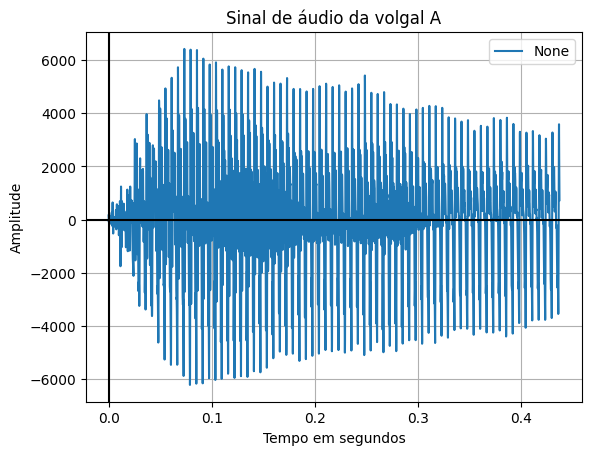

In [110]:
#Vogal A
fs_a, Vg_a = wav.read('2 - Fourier_Vogais_a.wav')
Na, T1a, Ta, Pico_a, Ttot_a = extrai_vogal(fs_a, Vg_a)
plotar_grafico(Ta, Vg_a, 'Sinal de áudio da volgal A', label_x='Tempo em segundos', label_y='Amplitude')
Audio(Vg_a, rate=fs_a)


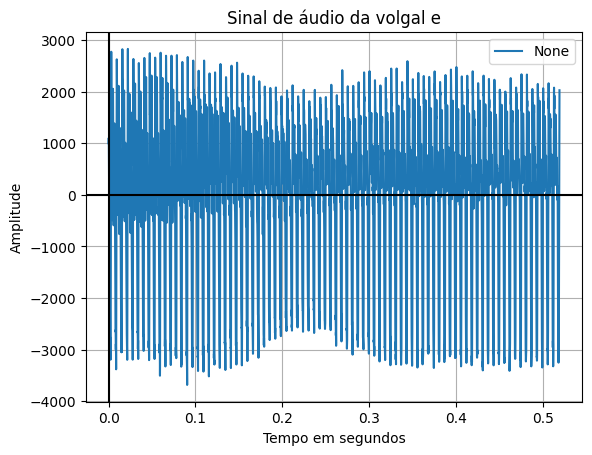

In [111]:
#Vogal E
fs_e, Vg_e = wav.read('2 - Fourier_Vogais_e.wav')
Ne, T1e, Te, Pico_e , Ttot_e = extrai_vogal(fs_e, Vg_e)
plotar_grafico(Te, Vg_e, 'Sinal de áudio da volgal e', label_x='Tempo em segundos', label_y='Amplitude')
Audio(Vg_e, rate=fs_e)

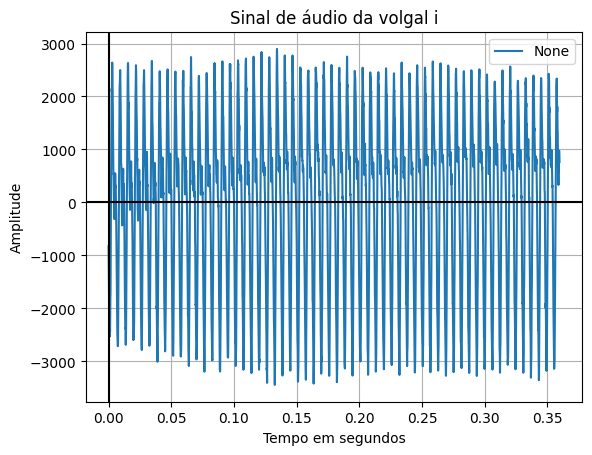

In [112]:
#Vogal I
fs_i, Vg_i = wav.read('2 - Fourier_Vogais_i.wav')
Ni, T1i, Ti, Pico_i, Ttot_i = extrai_vogal(fs_i, Vg_i)
plotar_grafico(Ti, Vg_i, 'Sinal de áudio da volgal i', label_x='Tempo em segundos', label_y='Amplitude')
Audio(Vg_i, rate=fs_i)

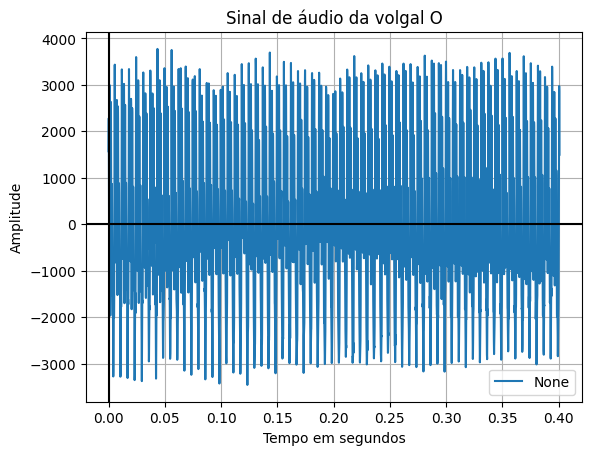

In [113]:
#Vogal O
fs_o, Vg_o = wav.read('2 - Fourier_Vogais_o.wav')
No, T1o, To, Pico_o, Ttot_o = extrai_vogal(fs_o, Vg_o)
plotar_grafico(To, Vg_o, 'Sinal de áudio da volgal O', label_x='Tempo em segundos', label_y='Amplitude')
Audio(Vg_o, rate=fs_o)

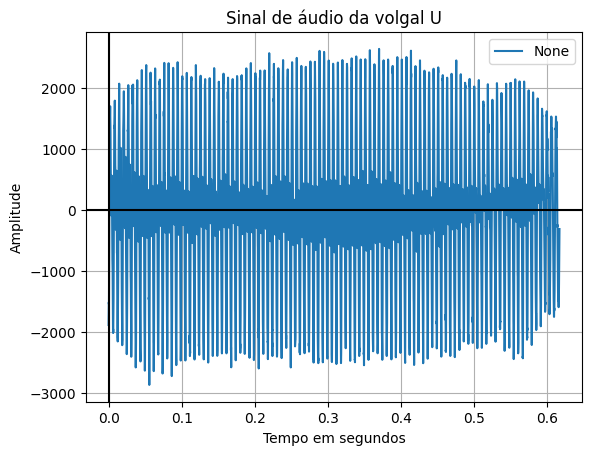

In [114]:
#Vogal U
fs_u, Vg_u = wav.read('2 - Fourier_Vogais_u.wav')
Nu, T1u, Tu, Pico_u, Ttot_u = extrai_vogal(fs_u, Vg_u)
plotar_grafico(Tu, Vg_u, 'Sinal de áudio da volgal U', label_x='Tempo em segundos', label_y='Amplitude')
Audio(Vg_u, rate=fs_u)

## Ponderando as vogais

<module 'matplotlib.pyplot' from 'c:\\Users\\rafae\\AppData\\Local\\Programs\\Python\\Python310\\lib\\site-packages\\matplotlib\\pyplot.py'>

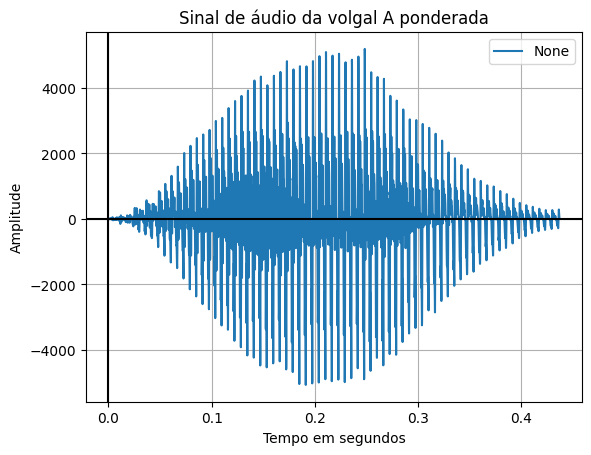

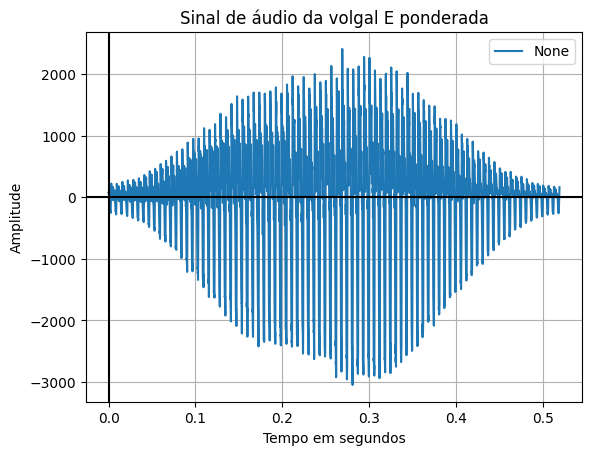

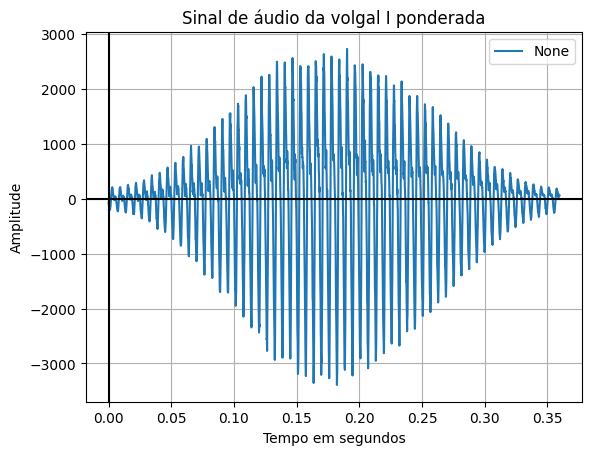

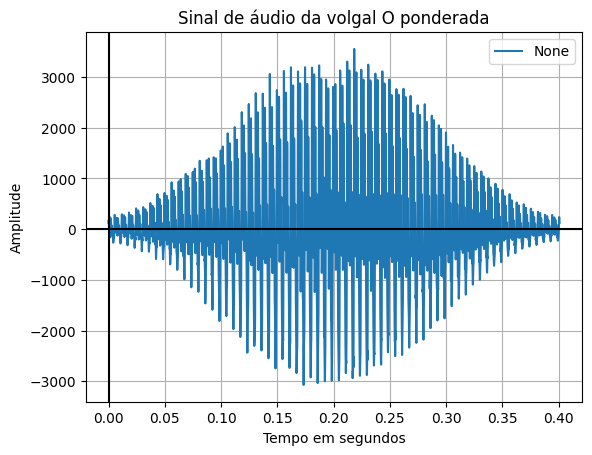

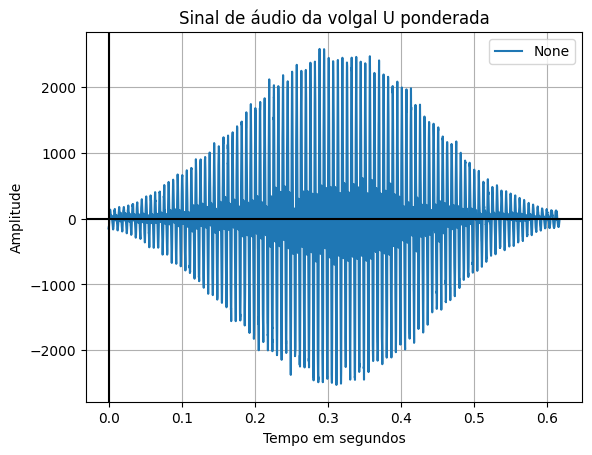

In [115]:
#Vogal A ponderada
Vg_ap = ponderar_vogal(Na, Vg_a)
plotar_grafico(Ta, Vg_ap, 'Sinal de áudio da volgal A ponderada', label_x='Tempo em segundos', label_y='Amplitude', n_figure=3)

#Vogal E ponderada
Vg_ep = ponderar_vogal(Ne, Vg_e)
plotar_grafico(Te, Vg_ep, 'Sinal de áudio da volgal E ponderada', label_x='Tempo em segundos', label_y='Amplitude', n_figure=4)

#Vogal I ponderada
Vg_ip = ponderar_vogal(Ni, Vg_i)
plotar_grafico(Ti, Vg_ip, 'Sinal de áudio da volgal I ponderada', label_x='Tempo em segundos', label_y='Amplitude', n_figure=5)

#Vogal O ponderada
Vg_op = ponderar_vogal(No, Vg_o)
plotar_grafico(To, Vg_op, 'Sinal de áudio da volgal O ponderada', label_x='Tempo em segundos', label_y='Amplitude', n_figure=6)

#Vogal U ponderada
Vg_up = ponderar_vogal(Nu, Vg_u)
plotar_grafico(Tu, Vg_up, 'Sinal de áudio da volgal U ponderada', label_x='Tempo em segundos', label_y='Amplitude', n_figure=7)

#  Encontrar a frequência fundamental de cada vogal

## Vogal A

Frequência fundamental da vogal A:159.14Hz


<module 'matplotlib.pyplot' from 'c:\\Users\\rafae\\AppData\\Local\\Programs\\Python\\Python310\\lib\\site-packages\\matplotlib\\pyplot.py'>

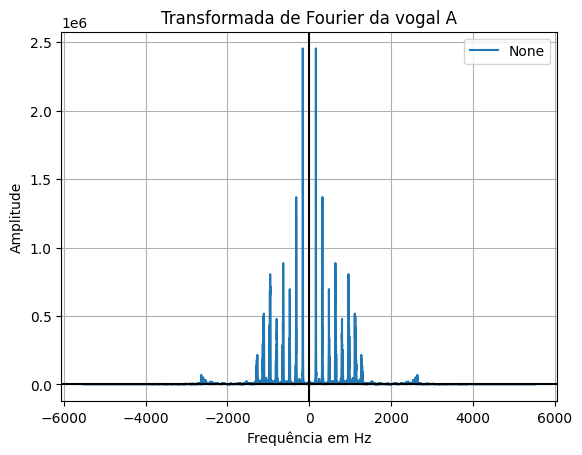

In [138]:
#Vogal A Fourier
Fourier_a, frequencia_a, freq_fund_a = calcula_fourier(Vg_ap, fs_a)
print(f'Frequência fundamental da vogal A:{freq_fund_a:,.2f}Hz')
plotar_grafico(frequencia_a, Fourier_a, 'Transformada de Fourier da vogal A', label_x='Frequência em Hz', label_y='Amplitude')

# Vogal E

Frequência fundamental da vogal E:157.06Hz


<module 'matplotlib.pyplot' from 'c:\\Users\\rafae\\AppData\\Local\\Programs\\Python\\Python310\\lib\\site-packages\\matplotlib\\pyplot.py'>

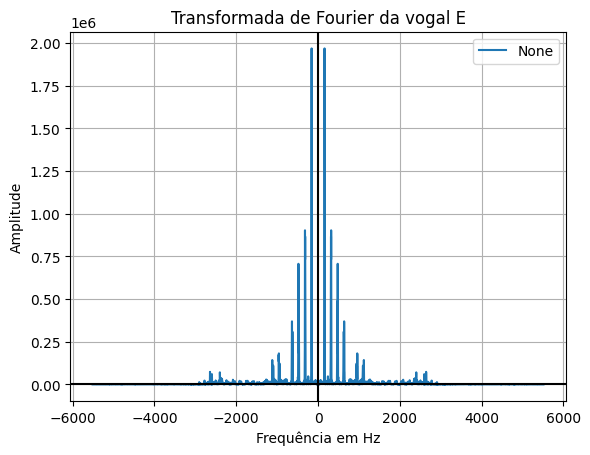

In [140]:
#Vogal E Fourier
Fourier_e, frequencia_e, freq_fund_e = calcula_fourier(Vg_ep, fs_e)
print(f'Frequência fundamental da vogal E:{freq_fund_e:,.2f}Hz')
plotar_grafico(frequencia_e, Fourier_e, 'Transformada de Fourier da vogal E', label_x='Frequência em Hz', label_y='Amplitude')

# Vogal I


Frequência fundamental da vogal I:159.88Hz


<module 'matplotlib.pyplot' from 'c:\\Users\\rafae\\AppData\\Local\\Programs\\Python\\Python310\\lib\\site-packages\\matplotlib\\pyplot.py'>

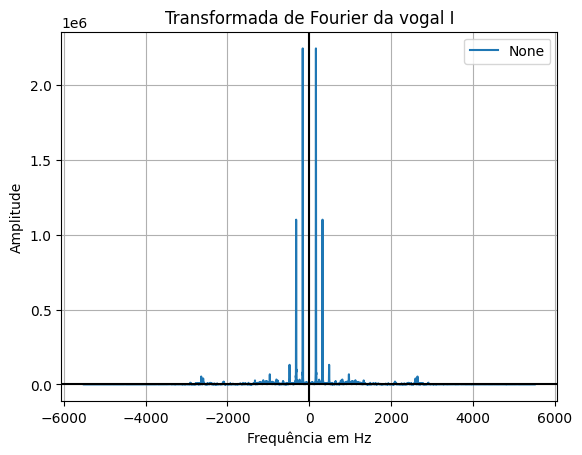

In [173]:
#Vogal I Fourier
Fourier_i, frequencia_i, freq_fund_i = calcula_fourier(Vg_ip, fs_i)
print(f'Frequência fundamental da vogal I:{freq_fund_i:,.2f}Hz')
plotar_grafico(frequencia_i, Fourier_i, 'Transformada de Fourier da vogal I', label_x='Frequência em Hz', label_y='Amplitude')

# Vogal O

Frequência fundamental da vogal O:159.71Hz


<module 'matplotlib.pyplot' from 'c:\\Users\\rafae\\AppData\\Local\\Programs\\Python\\Python310\\lib\\site-packages\\matplotlib\\pyplot.py'>

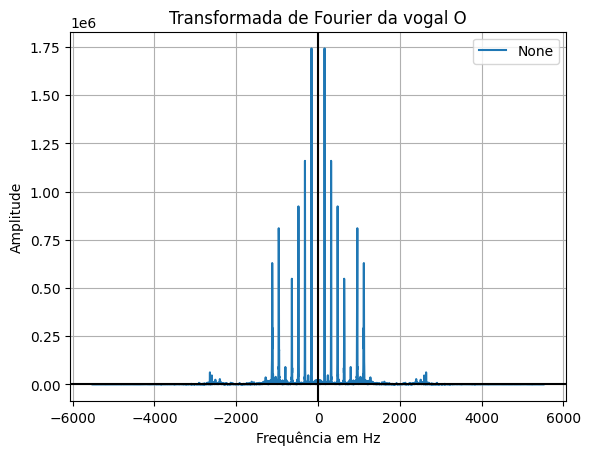

In [172]:
#Vogal O Fourier
Fourier_o, frequencia_o, freq_fund_o = calcula_fourier(Vg_op, fs_o)
print(f'Frequência fundamental da vogal O:{freq_fund_o:,.2f}Hz')
plotar_grafico(frequencia_o, Fourier_o, 'Transformada de Fourier da vogal O', label_x='Frequência em Hz', label_y='Amplitude')

# Vogal U

Frequência fundamental da vogal U:160.56Hz


<module 'matplotlib.pyplot' from 'c:\\Users\\rafae\\AppData\\Local\\Programs\\Python\\Python310\\lib\\site-packages\\matplotlib\\pyplot.py'>

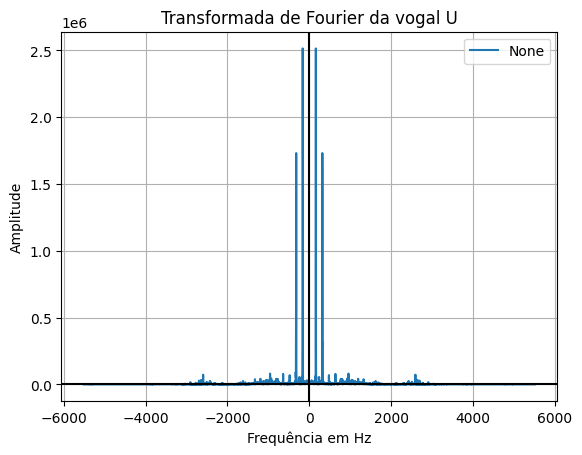

In [171]:
#Vogal U Fourier
Fourier_u, frequencia_u, freq_fund_u = calcula_fourier(Vg_up, fs_u)
print(f'Frequência fundamental da vogal U:{freq_fund_u:,.2f}Hz')
plotar_grafico(frequencia_u, Fourier_u, 'Transformada de Fourier da vogal U', label_x='Frequência em Hz', label_y='Amplitude')

## Encontrando as formantes

Primeira formante da vogal A:161.43Hz
Segunda formante da vogal A:958.25Hz
Terceira formante da vogal A:2,643.48Hz


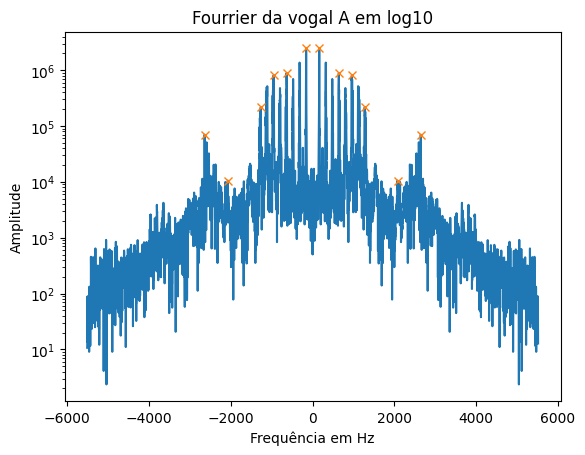

In [195]:
picos_form_a, _ = find_peaks(Fourier_a, height=0, distance=130, prominence=10000)
plt.figure()
plt.plot(frequencia_a, np.abs(Fourier_a))
plt.title('Fourrier da vogal A em log10')
plt.xlabel('Frequência em Hz')
plt.ylabel('Amplitude')
plt.yscale('log')
plt.plot(frequencia_a[picos_form_a], np.abs(Fourier_a[picos_form_a]), "x")

print(f'Primeira formante da vogal A:{frequencia_a[picos_form_a[6]]:,.2f}Hz')
print(f'Segunda formante da vogal A:{frequencia_a[picos_form_a[8]]:,.2f}Hz')
print(f'Terceira formante da vogal A:{frequencia_a[picos_form_a[11]]:,.2f}Hz')




# Obtendo outras informações das vogais

### Vogai com audio cortado

A partir desse ponto a função plotar_grafico não esta sendo utilizada pois plotando os graficos de fomra individual a visualização fica melhor e ainda não encontrei uma forma de corrigir isso

Text(0, 0.5, 'Amplitude')

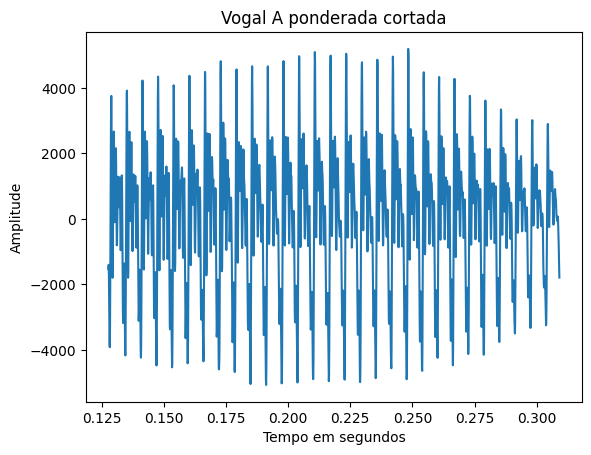

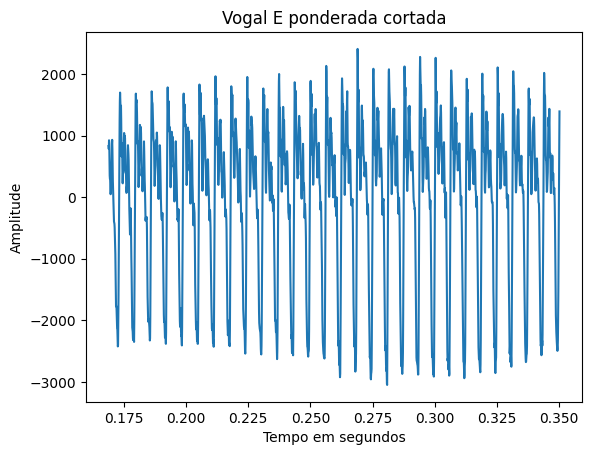

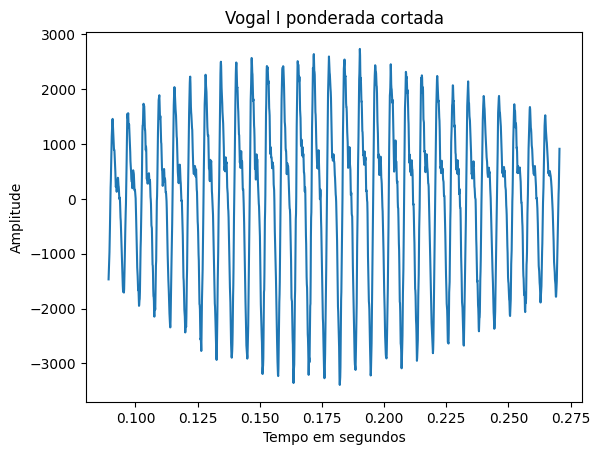

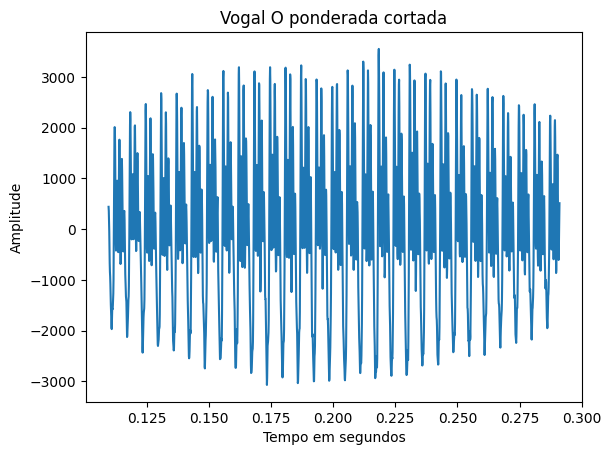

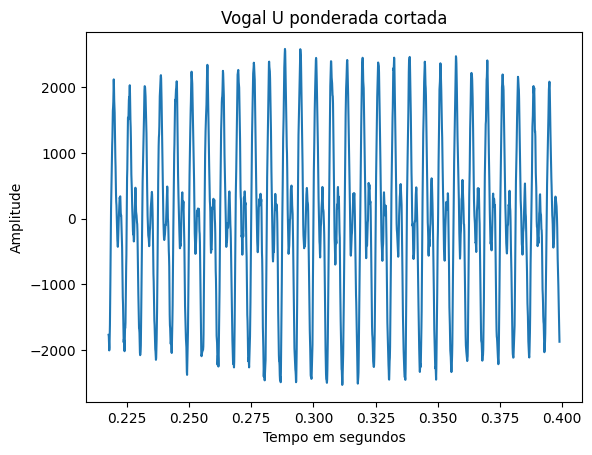

In [125]:
Ta2, Vg_a2 = corta_vogal(Vg_ap, Ta)
plt.figure(8)
plt.plot(Ta2, Vg_a2)
plt.title('Vogal A ponderada cortada')
plt.xlabel('Tempo em segundos')
plt.ylabel('Amplitude')


Te2, Vg_e2 = corta_vogal(Vg_ep, Te)
plt.figure(9)
plt.plot(Te2, Vg_e2)
plt.title('Vogal E ponderada cortada')
plt.xlabel('Tempo em segundos')
plt.ylabel('Amplitude')

Ti2, Vg_i2 = corta_vogal(Vg_ip, Ti)
plt.figure(10)
plt.plot(Ti2, Vg_i2)
plt.title('Vogal I ponderada cortada')
plt.xlabel('Tempo em segundos')
plt.ylabel('Amplitude')

To2, Vg_o2 = corta_vogal(Vg_op, To)
plt.figure(11)
plt.plot(To2, Vg_o2)
plt.title('Vogal O ponderada cortada')
plt.xlabel('Tempo em segundos')
plt.ylabel('Amplitude')

Tu2, Vg_u2 = corta_vogal(Vg_up, Tu)
plt.figure(12)
plt.plot(Tu2, Vg_u2)
plt.title('Vogal U ponderada cortada')
plt.xlabel('Tempo em segundos')
plt.ylabel('Amplitude')




## Achando os picos

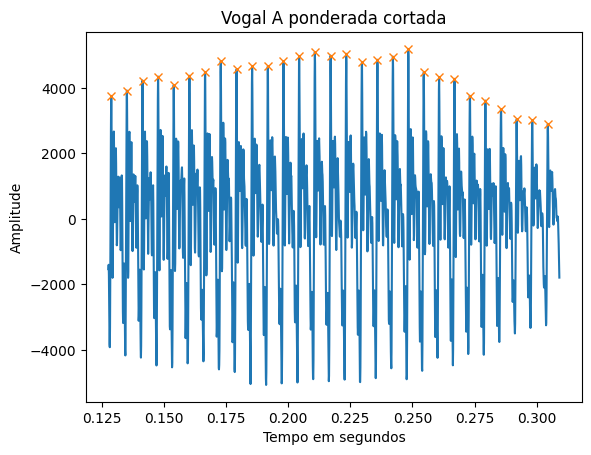

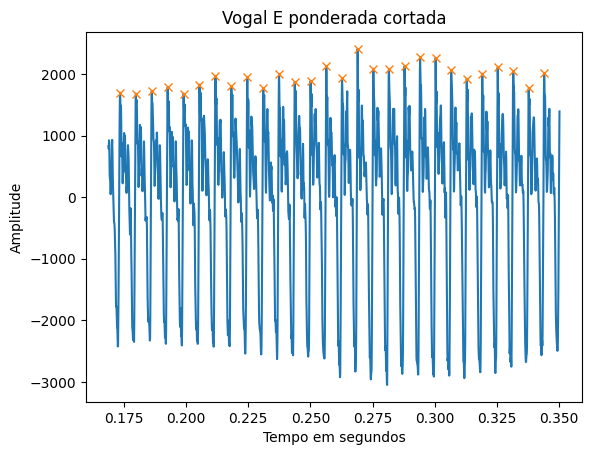

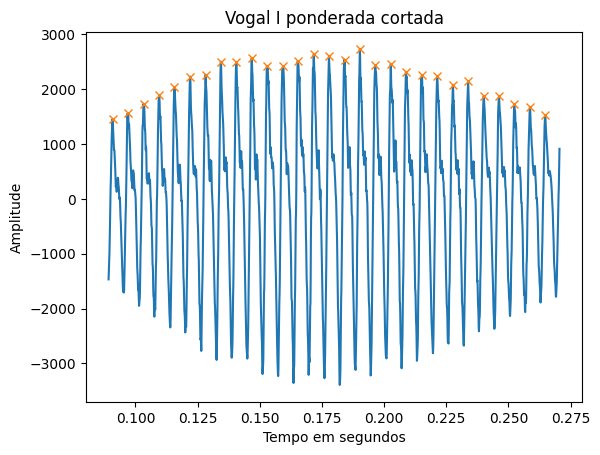

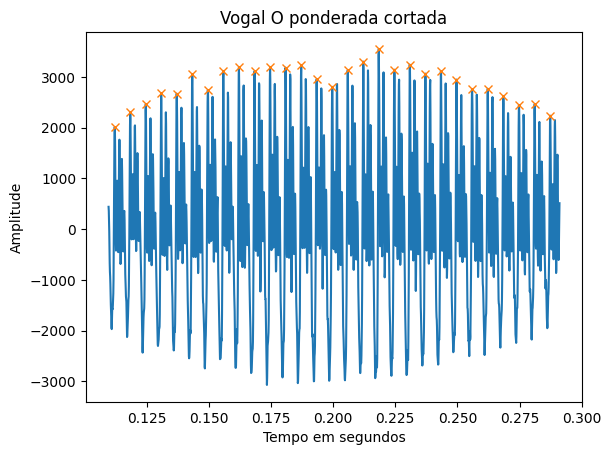

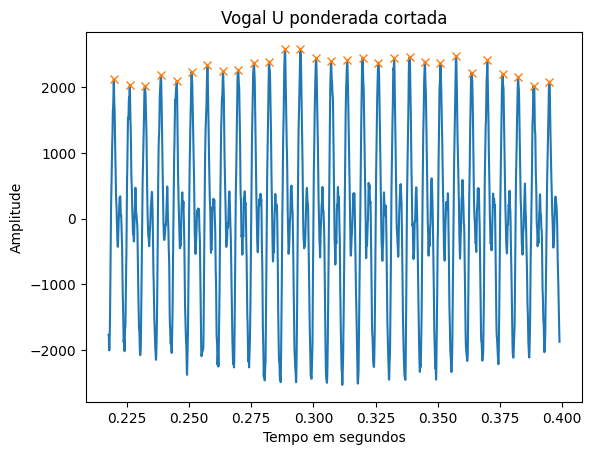

In [126]:
picos_a = picos_vogal(Vg_a2)
plt.figure(13)
plt.plot(Ta2, Vg_a2)
plt.title('Vogal A ponderada cortada')
plt.xlabel('Tempo em segundos')
plt.ylabel('Amplitude')
plt.plot(Ta2[picos_a], Vg_a2[picos_a], "x")

picos_e = picos_vogal(Vg_e2)
plt.figure(14)
plt.plot(Te2, Vg_e2)
plt.title('Vogal E ponderada cortada')
plt.xlabel('Tempo em segundos')
plt.ylabel('Amplitude')
plt.plot(Te2[picos_e], Vg_e2[picos_e], "x")

picos_i = picos_vogal(Vg_i2)
plt.figure(15)
plt.plot(Ti2, Vg_i2)
plt.title('Vogal I ponderada cortada')
plt.xlabel('Tempo em segundos')
plt.ylabel('Amplitude')
plt.plot(Ti2[picos_i], Vg_i2[picos_i], "x")

picos_o = picos_vogal(Vg_o2)
plt.figure(16)
plt.plot(To2, Vg_o2)
plt.title('Vogal O ponderada cortada')
plt.xlabel('Tempo em segundos')
plt.ylabel('Amplitude')
plt.plot(To2[picos_o], Vg_o2[picos_o], "x")

picos_u = picos_vogal(Vg_u2)
plt.figure(17)
plt.plot(Tu2, Vg_u2)
plt.title('Vogal U ponderada cortada')
plt.xlabel('Tempo em segundos')
plt.ylabel('Amplitude')
plt.plot(Tu2[picos_u], Vg_u2[picos_u], "x")


## Picos em 1 período da vogal

Text(0, 0.5, 'Amplitude')

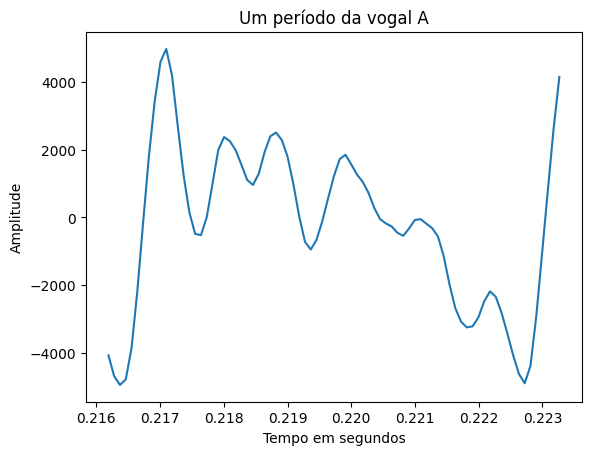

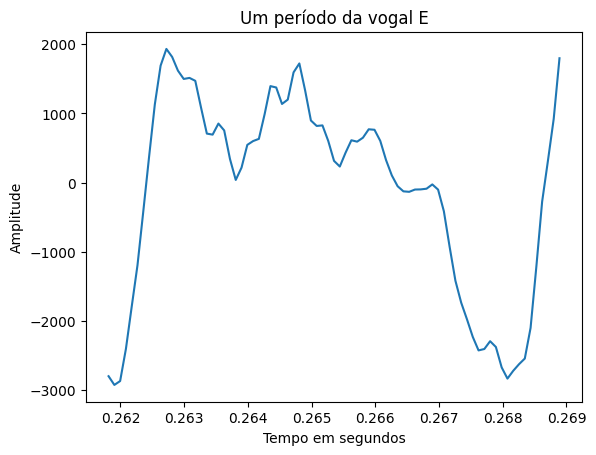

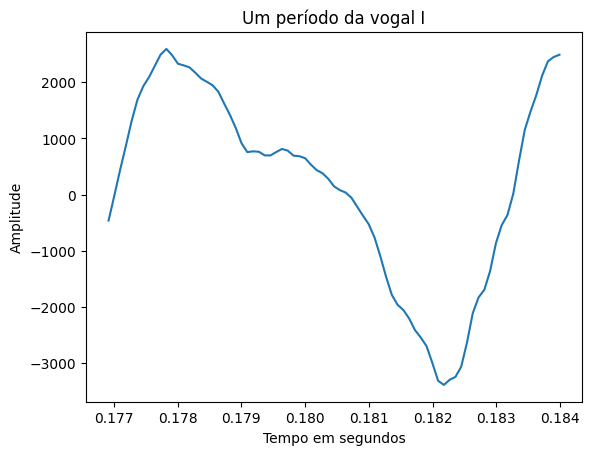

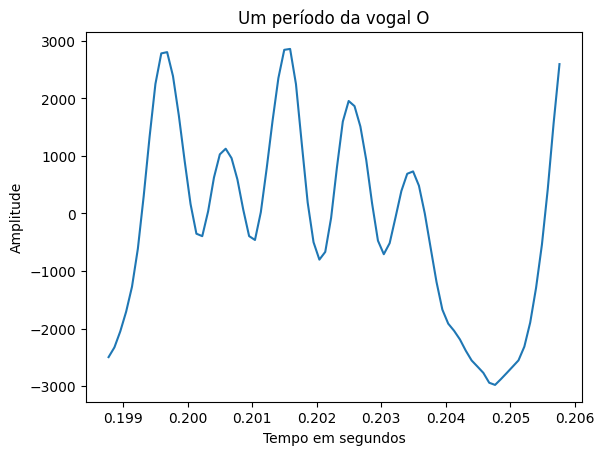

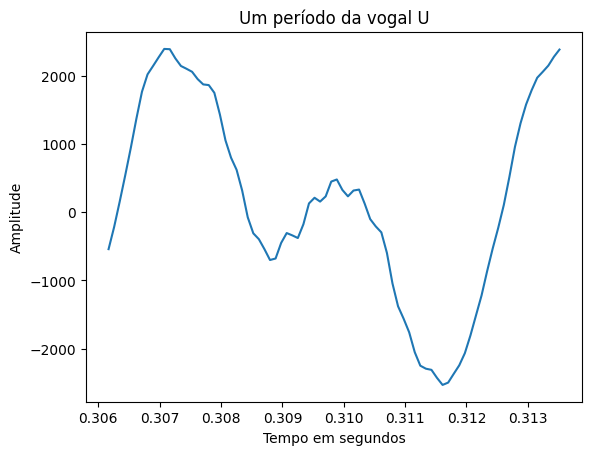

In [127]:
perido_ta, periodo_a = um_periodo(picos_a, Vg_a2, Ta2)
plt.figure(18)
plt.plot(perido_ta, periodo_a)
plt.title('Um período da vogal A')
plt.xlabel('Tempo em segundos')
plt.ylabel('Amplitude')

perido_te, periodo_e = um_periodo(picos_e, Vg_e2, Te2)
plt.figure(19)
plt.plot(perido_te, periodo_e)
plt.title('Um período da vogal E')
plt.xlabel('Tempo em segundos')
plt.ylabel('Amplitude')

perido_ti, periodo_i = um_periodo(picos_i, Vg_i2, Ti2)
plt.figure(20)
plt.plot(perido_ti, periodo_i)
plt.title('Um período da vogal I')
plt.xlabel('Tempo em segundos')
plt.ylabel('Amplitude')

perido_to, periodo_o = um_periodo(picos_o, Vg_o2, To2)
plt.figure(21)
plt.plot(perido_to, periodo_o)
plt.title('Um período da vogal O')
plt.xlabel('Tempo em segundos')
plt.ylabel('Amplitude')

perido_tu, periodo_u = um_periodo(picos_u, Vg_u2, Tu2)
plt.figure(22)
plt.plot(perido_tu, periodo_u)
plt.title('Um período da vogal U')
plt.xlabel('Tempo em segundos')
plt.ylabel('Amplitude')


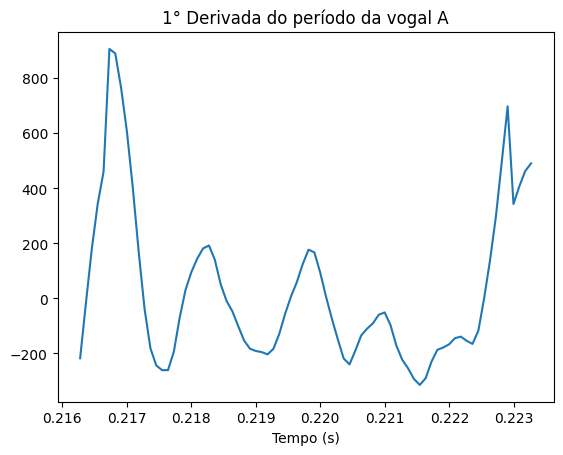

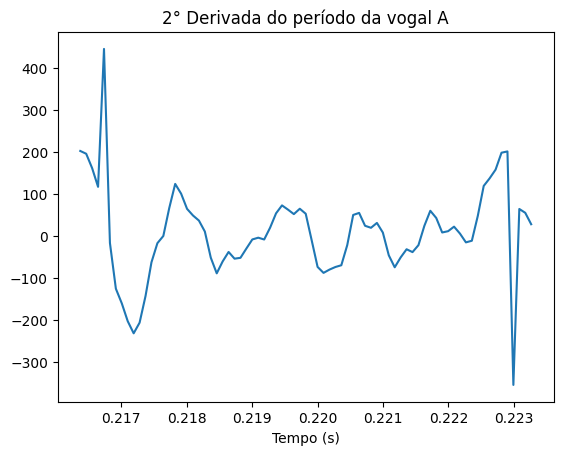

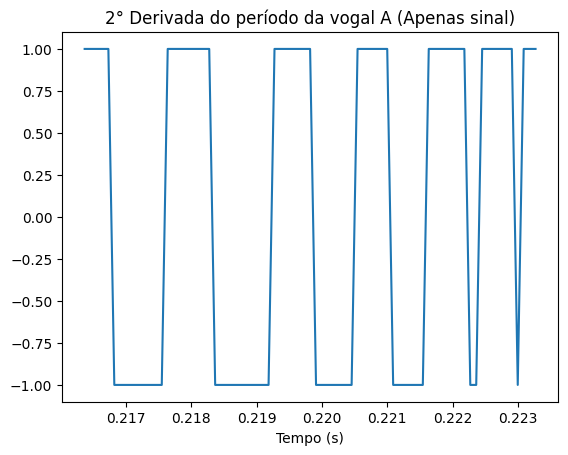

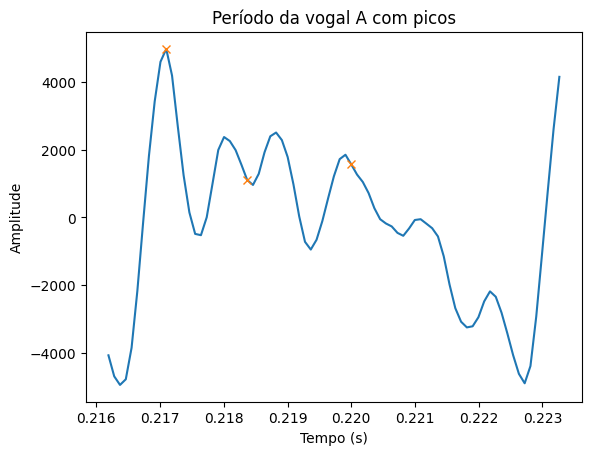

In [128]:
zero_a = picos_periodo(periodo_a, perido_ta, 'A')


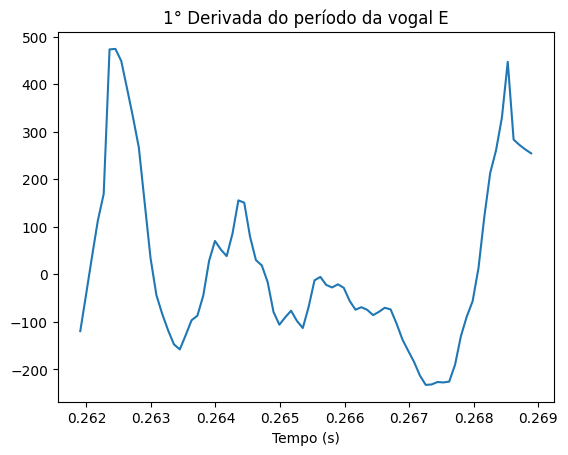

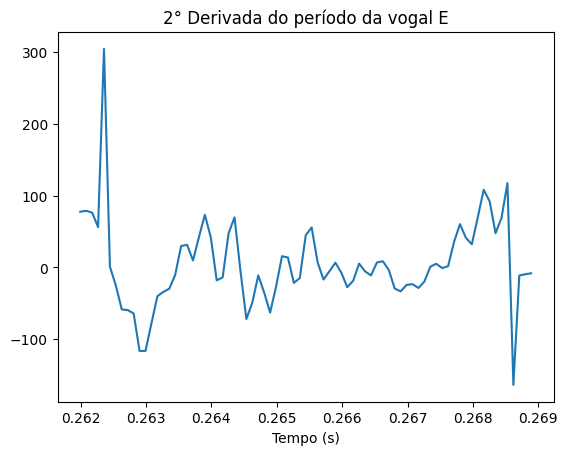

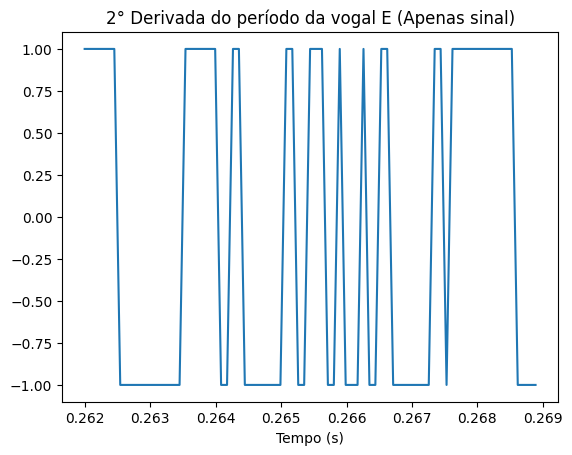

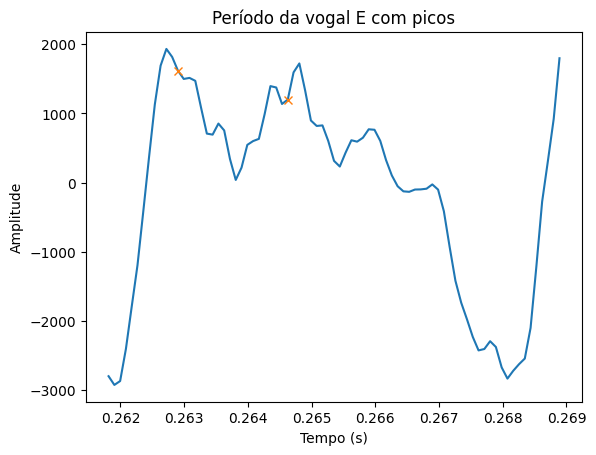

In [129]:
zero_e = picos_periodo(periodo_e, perido_te, 'E')

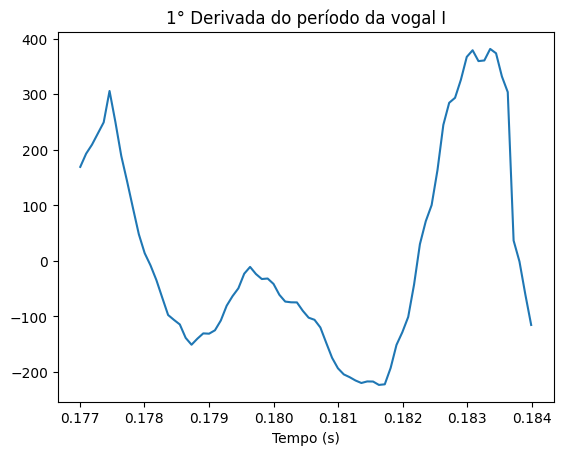

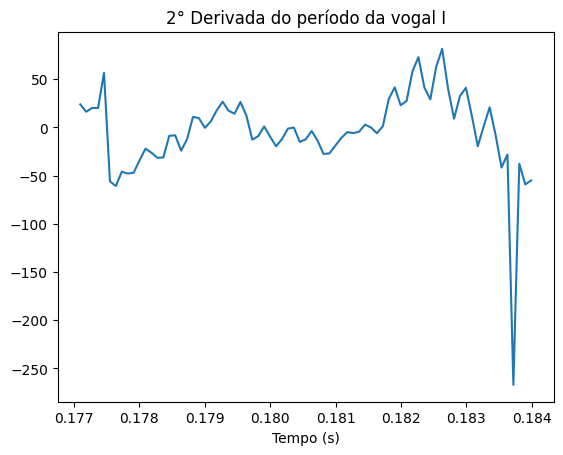

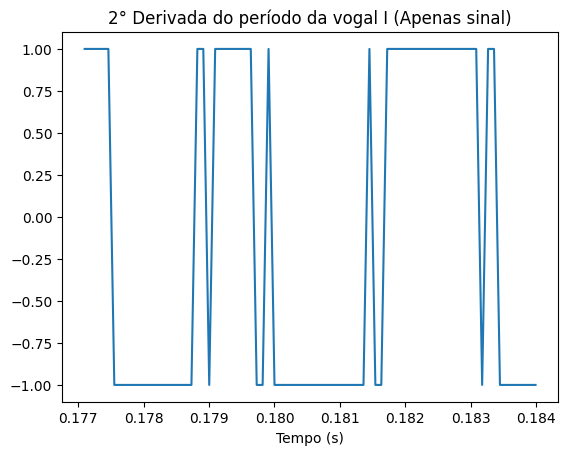

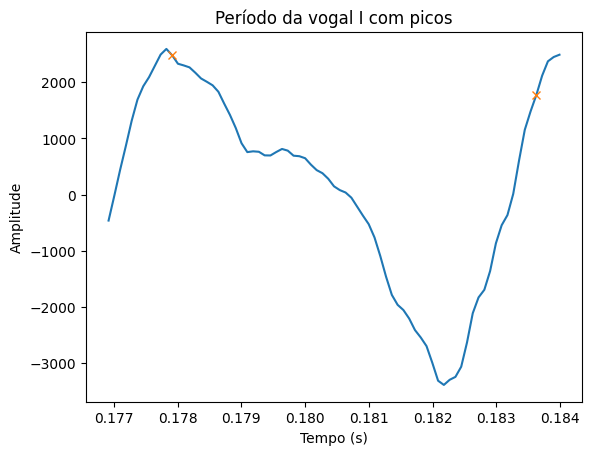

In [130]:
zero_i = picos_periodo(periodo_i, perido_ti, 'I')

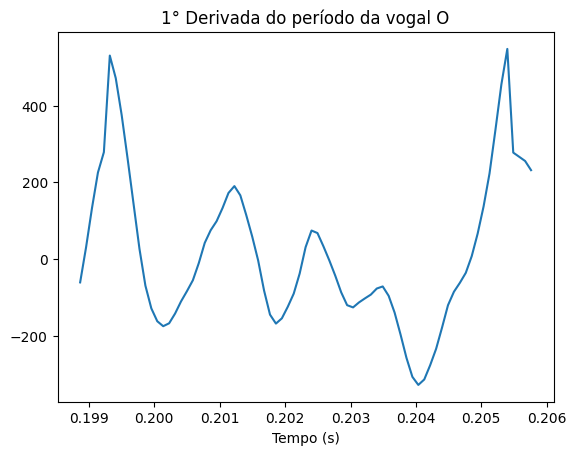

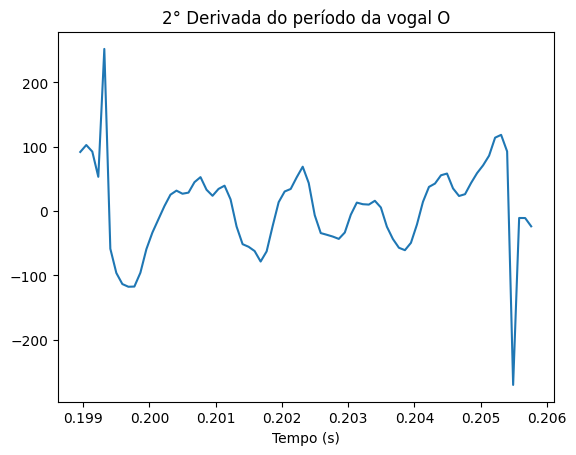

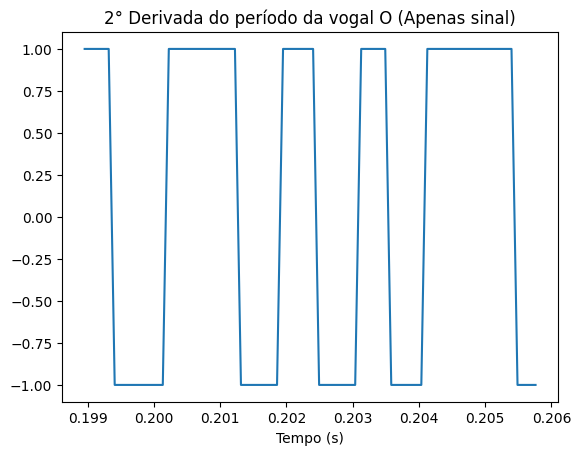

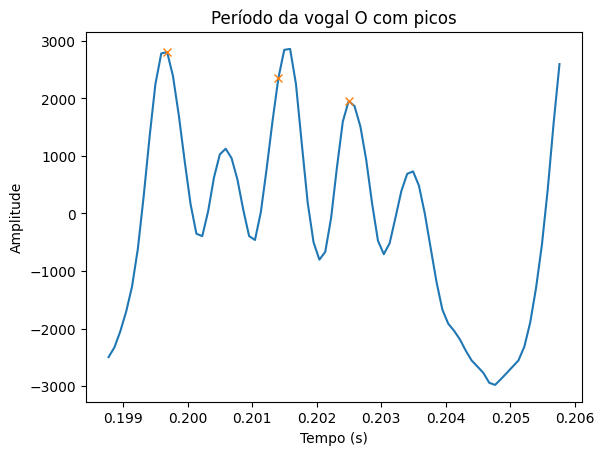

In [131]:
zero_o = picos_periodo(periodo_o, perido_to, 'O')

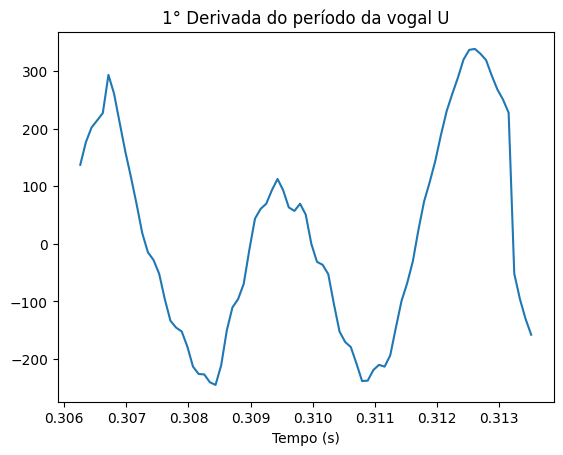

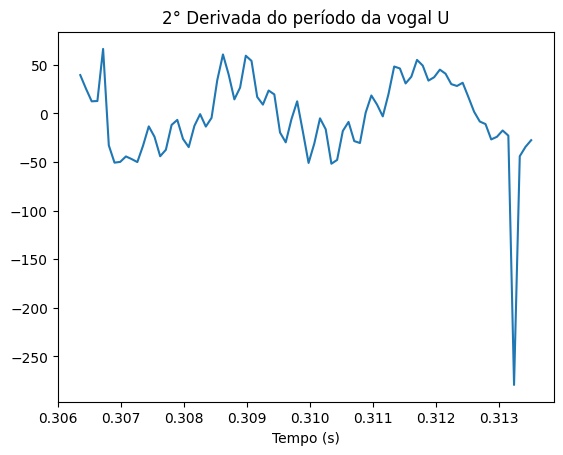

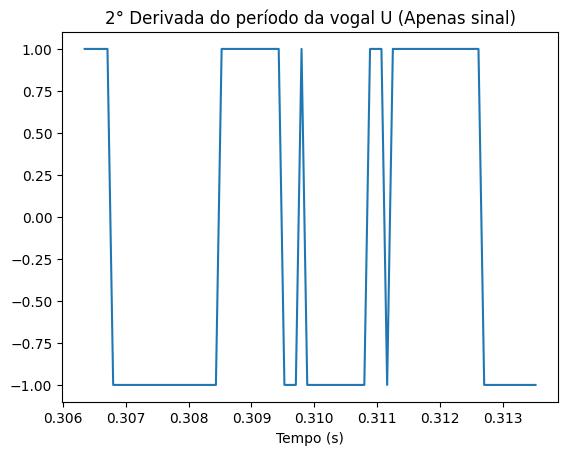

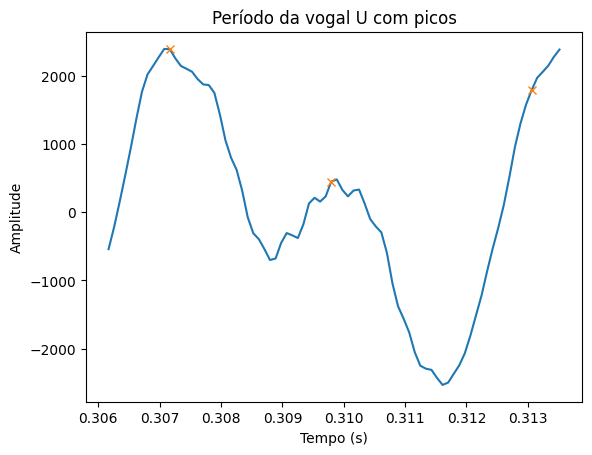

In [132]:
zero_u = picos_periodo(periodo_u, perido_tu, 'U')

# 3. Encontrar a função de Laplace para um trecho de uma determinada vogal 